In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# New Section

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools



In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/My Drive/Colab Notebooks/data/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/My Drive/Colab Notebooks/data/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/My Drive/Colab Notebooks/data/validation/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/My Drive/Colab Notebooks/data/validation/malignant',224))


100%|██████████| 251/251 [01:55<00:00,  2.17it/s]


In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)


   

NameError: ignored

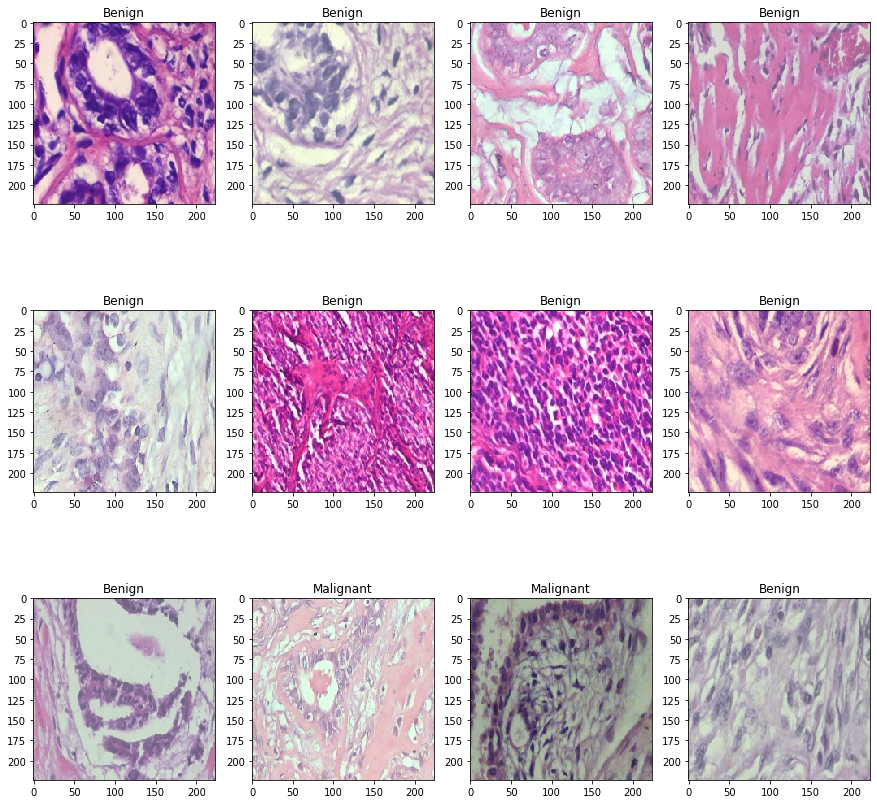

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

K.clear_session()
gc.collect()
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

74842112/74836368 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/weights.best.hdf5')

Epoch 1/2
57/56 [==============================] - 45s 784ms/step - loss: 0.2444 - accuracy: 0.9272 - val_loss: 0.4177 - val_accuracy: 0.8855

Epoch 00001: val_accuracy improved from -inf to 0.88546, saving model to /content/drive/My Drive/Colab Notebooks/weights.best.hdf5
Epoch 2/2
57/56 [==============================] - 44s 778ms/step - loss: 0.1985 - accuracy: 0.9316 - val_loss: 0.1203 - val_accuracy: 0.9648

Epoch 00002: val_accuracy improved from 0.88546 to 0.96476, saving model to /content/drive/My Drive/Colab Notebooks/weights.best.hdf5


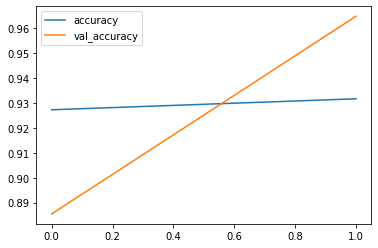

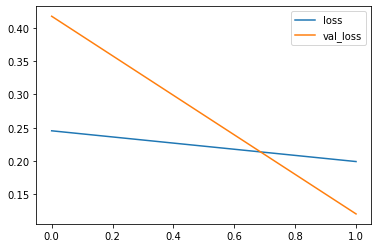

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Colab Notebooks/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

with open('/content/history.json', 'w') as f:
    json.dump(str(history.history), f)

    history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

model.load_weights("/content/weights.best.hdf5")


100%|██████████| 10/10 [01:25<00:00,  8.51s/it]


Confusion matrix, without normalization
[[241  11]
 [ 77 174]]
(224, 224, 3)
0.9860898
Benign
0.9802229
Benign
0.9891004
Benign
0.9757878
Benign
0.9810182
Benign
0.98708236
Benign
0.99142504
Benign
0.9839176
Benign
0.98933125
Benign
0.99544203
Benign
0.9875544
Benign
0.9882058
Benign
0.99125916
Benign
0.98526776
Benign
0.9962513
Benign
0.984108
Benign
0.97869396
Benign
0.99425066
Benign
0.9879915
Benign
0.9932287
Benign
2.133199e-28
Malignant
6.6912782e-18
Malignant
2.5936423e-24
Malignant
2.323033e-28
Malignant
2.5126743e-13
Malignant
2.7464099e-25
Malignant
6.831285e-22
Malignant
5.439762e-26
Malignant
1.319481e-27
Malignant
9.127707e-07
Malignant
1.4204117e-18
Malignant
4.6513223e-22
Malignant
6.819102e-29
Malignant
4.4806492e-10
Malignant
1.7449796e-24
Malignant
2.5288165e-19
Malignant
6.3189227e-28
Malignant
3.1089853e-15
Malignant
9.352915e-21
Malignant
2.0054315e-20
Malignant


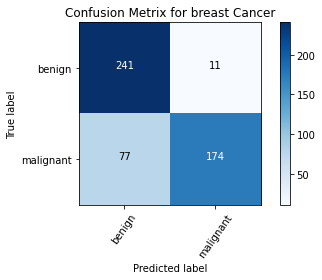

In [ ]:
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

Y_pred = model.predict(X_test)

tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for breast Cancer')

# print(y_val)
print(x_val[0].shape)

model.load_weights("/content/drive/My Drive/Colab Notebooks/weights.best.hdf5")

# np.reshape(im,(460, 700, 4))
# print(im)
prediction = model.predict(benign_train)
for i in range(20):
  if(prediction[i][0]<0.05):
    print(prediction[i][0])
    print('Malignant')
  else:
    print(prediction[i][0])
    print('Benign')



prediction = model.predict(malign_train)
for i in range(20):
  if(prediction[i][0]<0.05):
    print(prediction[i][0])
    print('Malignant')
  else:
    print(prediction[i][0])
    print('Benign')

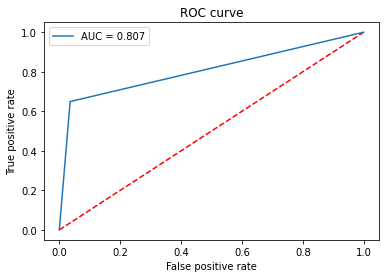

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()